In [18]:
# Ici nous reprenous avec des données différentes de même source, ici seulement sur le monde entier et quelques 1000 colonnes diverses (indicateurs de développement, économiques, sociaux, etc.)

In [ ]:
# Nous allons tester un modèle LSTM avec séquence de plusieurs années

In [20]:
import pandas as pd
from IPython.display import display
import warnings
import random
warnings.filterwarnings("ignore")
# InteractiveShell.ast_node_interactivity = "all"
random.seed(7)

data = pd.read_csv("data/world.csv", encoding="latin1")
print(data.columns)


rename_dict = {}
# Renommer colonnes : 1960 [YR1960] => YR1960
for col in data.columns:
    if col[0].isdigit():
        rename_dict[col] = col[:4]
data = data.rename(columns=rename_dict)
        
# remettre données année en ligne et variable en colonne



data = pd.melt(data, id_vars=list(data.columns[0:2]), value_vars = list(data.columns[2:]))
data = data.rename(columns={"variable":"Year"})
print(data.columns)

# data_unique = data.drop_duplicates(subset=["Country Name", "Year", "Series Name"])


# Pivot pour que les valeurs de "Series Name" deviennent des colonnes
data_pivot = data.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Name",
    values="value",
    aggfunc='first'  
)

data_pivot = data_pivot.reset_index()
data = data_pivot

print(type(data["Year"]))
data.sort_values("Year")

Index(['Country Name', 'Series Name', '2023', '2022', '2021', '2020', '2019',
       '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010',
       '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001',
       '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992',
       '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984', '1983',
       '1982', '1981', '1980', '1979', '1978', '1977', '1976', '1975', '1974',
       '1973', '1972', '1971', '1970', '1969', '1968', '1967', '1966', '1965',
       '1964', '1963', '1962', '1961', '1960'],
      dtype='object')
Index(['Country Name', 'Series Name', 'Year', 'value'], dtype='object')
<class 'pandas.core.series.Series'>


Series Name,Country Name,Year,"(depicting relative country price levels) are estimated simultaneously from a system of linear equations. http://stats.oecd.org/glossary/detail.asp?ID=5528""",>90% of species evaluated). Also,India,"OECD. The methodology used to determine high-tech exports takes the ""product approach"" based on R&D intensity on products from Germany","SDGs include targets 14 and 15 to highlight the importance of marine and terrestorial protected areas. Increasing the proportion of terrestrial and marine areas protected helps defend vulnerable plant and animal species and safeguard biodiversity.""","Third Revision (1990). The discussion of the ISIC draws on Ryten (1998).""",a better estimate of tourism-related expenditure by inbound and outbound visitors in an international scenario would be,a new item in the Balance of Payments (BPM6) represents a broader definition of worker remittances. Personal transfers include all current transfers in cash or in kind between resident and nonresident individuals,...,"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)","Water productivity, total (constant 2015 US$ GDP per cubic meter of total freshwater withdrawal)",Women Business and the Law Index Score (scale 1-100),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
14078,World,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14079,World,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14080,World,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.73011,NaN,NaN,NaN
14081,World,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60.325023,NaN,NaN,NaN
14082,World,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60.464933,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8594,SE.SEC.TCAQ.UP.FE.ZS,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8604,SE.SEC.TCAQ.UP.MA.ZS,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8614,SE.SEC.TCAQ.UP.ZS,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8534,SE.SEC.PROG.ZS,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


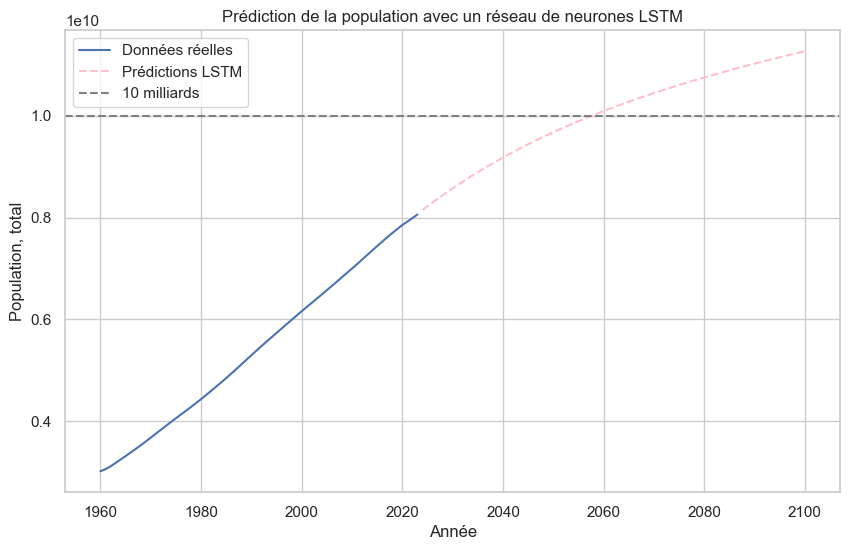

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# On suppose que 'data' contient déjà le dataset complet
df = data.copy()
df = df[df["Country Name"] == "World"]

# Conversion de la colonne "Year" en numérique si nécessaire
df["Year"] = pd.to_numeric(df["Year"], errors='coerce')
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

# Tri par année
df = df.sort_values("Year")

# Sélection des colonnes d'intérêt et conversion en float
df = df[["Year", "Population, total"]].copy()
df["Population, total"] = df["Population, total"].astype(float)

# Normalisation des données (facilite l'apprentissage du réseau)
scaler = MinMaxScaler()
df["Population_scaled"] = scaler.fit_transform(df[["Population, total"]])

# Fonction pour créer des séquences temporelles (fenêtre de 5 ans)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 5
X, y = create_sequences(df["Population_scaled"].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Association de chaque séquence à l'année cible correspondante
years_seq = df["Year"].values[window_size:]

# Séparation en ensemble d'entraînement (< 2015) et ensemble de test (>= 2015)
train_idx = np.where(years_seq < 2015)[0]
test_idx  = np.where(years_seq >= 2015)[0]
X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# Création du modèle LSTM (pour cette phase de cross-validation)
model_cv = Sequential()
model_cv.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model_cv.add(Dense(1))
model_cv.compile(optimizer='adam', loss='mse')

# Entraînement du modèle final sur toutes les données
model_final = Sequential()
model_final.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model_final.add(Dense(1))
model_final.compile(optimizer='adam', loss='mse')
model_final.fit(X, y, epochs=1000, batch_size=1, verbose=0)

# Calcul du R² sur l'ensemble des données d'entraînement
y_train_pred_scaled = model_final.predict(X)
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
y_true = scaler.inverse_transform(y.reshape(-1, 1))


# ---------------------------
# Prédiction jusqu'à l'année 2100
# ---------------------------
final_year = 2100
last_year = df["Year"].max()
num_predictions = final_year - last_year

# Démarrage avec la dernière séquence réelle
current_seq = df["Population_scaled"].values[-window_size:].tolist()
predictions = []
for _ in range(num_predictions):
    seq_input = np.array(current_seq).reshape((1, window_size, 1))
    pred_scaled = model_final.predict(seq_input, verbose=0)[0, 0]
    predictions.append(pred_scaled)
    # Mise à jour de la séquence pour la prochaine prédiction
    current_seq.append(pred_scaled)
    current_seq.pop(0)

# Conversion des prédictions à l'échelle d'origine
predictions_orig = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
years_future = np.arange(last_year + 1, final_year + 1)

# Affichage du graphique de prédiction
plt.figure(figsize=(10, 6))
plt.plot(df["Year"], df["Population, total"], label="Données réelles")
plt.plot(years_future, predictions_orig, label="Prédictions LSTM", linestyle="--", color="pink")
# Ajout de la ligne horizontale grise pointillée à 10 milliards
plt.axhline(y=10000000000, color='grey', linestyle='--', label="10 milliards")
plt.xlabel("Année")
plt.ylabel("Population, total")
plt.title("Prédiction de la population avec un réseau de neurones LSTM")
plt.legend()
plt.grid(True)
# Sauvegarde du graphique en PNG
plt.savefig("LSTM.png", dpi=300)
plt.show()
